In [1]:
import cirq
import qsimcirq
import numpy as np
import qiskit
import qiskit_ibm_runtime
from qiskit_aer import AerSimulator
import stimcirq
from qiskit.visualization import plot_histogram
from encoded.dj import dj, dj_steane
from encoded.LST import int_to_binary
import matplotlib.pyplot as plt

## Computer parameters

In [2]:
# Computer and qubits to use.
# Option 1: Use saved noise characteristics.
computer = qiskit_ibm_runtime.fake_provider.FakeKyiv()
#computer = AerSimulator()  # Noiseless simulator - use this for a sanity check to see all computed expectation
layout = {
    1 : [63, 64],
    7 : [61, 62, 63, 64, 65, 66, 67, 72, 73, 81, 82, 83, 84, 85]
    #7 : [117,122,123, 124, 125, 126, 127,136,137,143,144,145,146,147]
}

## Oracle definition

In [3]:
total_qubits = 2
# Random case
# oracleType, oracleValue = np.random.randint(2), np.random.randint(2)
# if oracleType == 1:
#     oracleValue = np.random.randint(1, 2**(total_qubits-1))

# Fixed case
oracleType, oracleValue = 1, 2**(total_qubits-1)-1
oracleType,oracleValue

(1, 1)

# Full connectivity

### Analog

In [4]:
n_shots = 600_000
noise = cirq.depolarize
noise_set = [0.0]#np.logspace(-5,-3,10)
infidelity_analog = []
for noise_ratio in noise_set:
    qreg = cirq.LineQubit.range(total_qubits)
    circuit = dj(qreg,oracleType,oracleValue)
    circuit.append(cirq.measure(qreg[:total_qubits-1], key="m"))
    circuit = circuit.with_noise(noise(noise_ratio))
    simulator = stimcirq.StimSampler()
    counts = simulator.run(circuit, repetitions=n_shots).histogram(key="m")
    # if oracleType==1:
    infidelity_analog.append(1-counts[int(int_to_binary(total_qubits-1,oracleValue))]/n_shots)
    # else:
    #     infidelity_analog.append(1-counts[int("0"*(total_qubits-1))]/n_shots)

### Encoded

In [ ]:
oracleType, oracleValue = 1, 2**(total_qubits-1)-1

# Steane codewords (you can get them by simulating the dj_steane without noise)
logical_1_codeword = ["1110000","0101010","1000110","0100101","0010011","1001001","1111111","0011100"]
logical_0_codeword = ["1011010","0001111","0000000","0110110","1101100","1010101","0111001","1100011"]


k = 2
qreg = cirq.LineQubit.range(7*k)
infidelity_encoded = []
for noise_ratio in noise_set:
    circuit= dj_steane(qreg,oracleType,oracleValue)
    circuit.append(cirq.measure(qreg[:7*(k-1)], key="m"))
    circuit = circuit.with_noise(noise(noise_ratio))
    simulator = stimcirq.StimSampler()
    counts = simulator.run(circuit, repetitions=n_shots).histogram(key="m")
    counts_logical_1 = 0
    for e in logical_1_codeword:
        counts_logical_1 += counts[int(e,2)]
    counts_logical_0 = 0
    for e in logical_0_codeword:
        counts_logical_0 += counts[int(e,2)]

    # if oracleType==1 and oracleValue ==1:
    infidelity_encoded.append(1-counts_logical_1/(counts_logical_1+counts_logical_0))
    # else:
        # infidelity_encoded.append(1-counts_logical_0/(counts_logical_1+counts_logical_0))



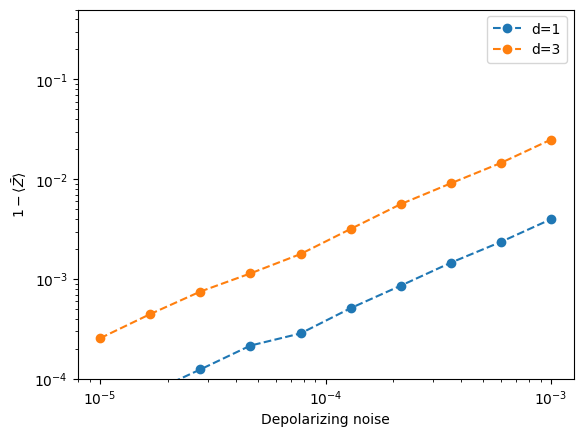

In [72]:
plt.figure()
plt.loglog(noise_set,infidelity_analog,"--o",label = "d=1")
plt.loglog(noise_set,infidelity_encoded,"--o",label = "d=3")


plt.ylim(1e-4,5e-1)
plt.xlabel("Depolarizing noise")
plt.ylabel(r"$1-\langle \bar{Z} \rangle$")
plt.legend()


# Transpiled

## Analog version

In [90]:


n_shots = 500_000
qreg = cirq.LineQubit.range(total_qubits)
circuit = dj(qreg,oracleType,oracleValue)
circuit.append(cirq.measure(qreg[:total_qubits-1], key="m"))
circuit = qiskit.QuantumCircuit.from_qasm_str(circuit.to_qasm())


compiled_raw = qiskit.transpile(
    circuit, 
    backend=computer,
    initial_layout=layout[1],  
    routing_method="sabre",
    optimization_level=0,
)

job = computer.run(compiled_raw, shots=n_shots)
counts = job.result().get_counts()


In [91]:
compiled_raw.draw(fold = -1)

global phase: 5π/4
                                                                                                                                                              
    ancilla_0 -> 0 ───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
                                                                                                                                                              
    ancilla_1 -> 1 ───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
                                                                                                                                                              
    ancilla_2 -> 2 ───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
                                                                                                                                                              
    ancilla_3 -> 3 ───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
                                                                                                                                                              
    ancilla_4 -> 4 ───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
                                                                                                                                                              
    ancilla_5 -> 5 ───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
                                                                                                                                                              
    ancilla_6 -> 6 ───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
                                                                                                                                                              
    ancilla_7 -> 7 ───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
                                                                                                                                                              
    ancilla_8 -> 8 ───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
                                                                                                                                                              
    ancilla_9 -> 9 ───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
                                                                                                                                                              
  ancilla_10 -> 10 ───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
                                                                                                                                                              
  ancilla_11 -> 11 ───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
                                                                                                                                                              
  anci

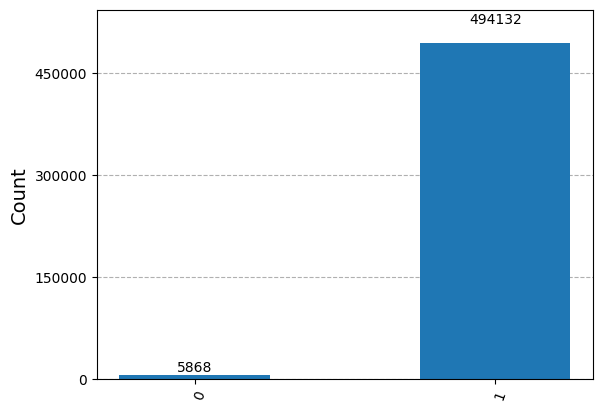

In [92]:
threshold = int(0.001 * n_shots) 
filteredAnswer = {k: v for k,v in counts.items() if v >= threshold}
removedCounts = np.sum([ v for k,v in counts.items() if v < threshold ]) 
plot_histogram(filteredAnswer)

In [93]:
if oracleType==1:
    print("Total fidelity F = ",counts[int_to_binary(total_qubits-1,oracleValue)]/n_shots*100,"%")
else:
    print("Total fidelity F = ",counts["0"*(total_qubits-1)]/n_shots*100,"%")

Total fidelity F =  98.8264 %


## Encoding the Steane code (k = 2)

In [94]:
oracleType, oracleValue = 1, 2**(total_qubits-1)-1

# Steane codewords (you can get them by simulating the dj_steane without noise)
logical_1_codeword = ["1110000","0101010","1000110","0100101","0010011","1001001","1111111","0011100"]
logical_0_codeword = ["1011010","0001111","0000000","0110110","1101100","1010101","0111001","1100011"]


k = 2
qreg = cirq.LineQubit.range(7*k)
circuit= dj_steane(qreg,oracleType,oracleValue)

circuit.append(cirq.measure(qreg[:7*(k-1)], key="m"))
circuit = qiskit.QuantumCircuit.from_qasm_str(circuit.to_qasm())


compiled_raw = qiskit.transpile(
    circuit, 
    backend=computer,
    #initial_layout=layout[7],
    routing_method="sabre", 
    optimization_level=3,
)
compiled_raw.count_ops()


OrderedDict([('rz', 279),
             ('sx', 158),
             ('ecr', 76),
             ('reset', 14),
             ('x', 7),
             ('measure', 7)])

In [95]:
compiled_raw.draw(fold = -1)

global phase: 0
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  
    ancilla_0 -> 0 ──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

In [96]:
job = computer.run(compiled_raw, shots=n_shots)
counts = job.result().get_counts()

In [97]:
counts

{'1101100': 188,
 '1110101': 277,
 '1001100': 304,
 '1010010': 437,
 '1010101': 202,
 '0111110': 427,
 '0110110': 201,
 '1000011': 303,
 '1100100': 406,
 '1001101': 1300,
 '1100011': 179,
 '1011010': 205,
 '0101100': 1077,
 '1101101': 781,
 '1110010': 894,
 '1010111': 1017,
 '0001111': 201,
 '0010000': 981,
 '0001101': 1034,
 '1101111': 1770,
 '0011010': 1060,
 '1101110': 890,
 '1010000': 3381,
 '1111100': 874,
 '0101110': 1256,
 '0111011': 915,
 '0110101': 1741,
 '1001000': 2064,
 '1000111': 2016,
 '0010110': 307,
 '0011000': 1488,
 '1001111': 1008,
 '0011110': 962,
 '1010110': 1858,
 '1011110': 1732,
 '0111101': 1746,
 '1000101': 1017,
 '0000111': 433,
 '1000100': 1034,
 '0000101': 3202,
 '1011111': 3209,
 '1110100': 1221,
 '1001011': 909,
 '0001100': 1965,
 '0001110': 982,
 '1000000': 1074,
 '1111101': 1017,
 '0110000': 2277,
 '0111010': 1830,
 '1101001': 2272,
 '0100000': 300,
 '1110110': 986,
 '0010010': 1949,
 '0100101': 39277,
 '0000011': 1878,
 '1011001': 1737,
 '1001110': 5079

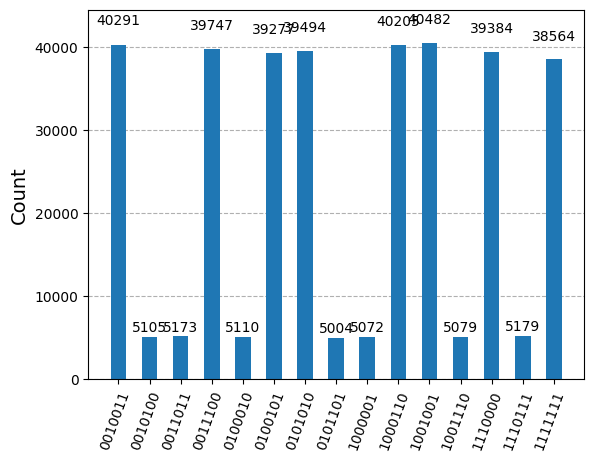

In [98]:
threshold = int(0.01 * n_shots)
filteredAnswer = {k: v for k,v in counts.items() if v >= threshold} 
removedCounts = np.sum([ v for k,v in counts.items() if v < threshold ]) 
plot_histogram(filteredAnswer)

### Using the encoding to take into account only the logical errors

In [89]:
counts_logical_1 = 0
for e in logical_1_codeword:
    counts_logical_1 += counts[e]
counts_logical_0 = 0
for e in logical_0_codeword:
    counts_logical_0 += counts[e]

if oracleType==1 and oracleValue ==1:
    print("Total fidelity F = ",counts_logical_1/(counts_logical_1+counts_logical_0)*100,"%")
else:
    print("Total fidelity F = ",counts_logical_0/(counts_logical_1+counts_logical_0)*100,"%")

Total fidelity F =  99.07926812377073 %
